# North Paramatta Upzoning Land Analysis

This is largely limited to what's on my system, which is zones and land values. 

In [1]:
# put this in it's own codeblock because it'll keep 
# running otherwise and eventually move to the root dir lol
%cd ../..

/Users/angus/code/jupyter/notebooks/20240907, vg


/Users/angus/code/jupyter/env/lib/python3.12/site-packages/IPython/core/magics/osm.py:417: UserWarning: This is now an optional IPython functionality, setting dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


## Setup the database

In [2]:
from lib.service.database import DatabaseService
from lib.defaults import INSTANCE_CFG

db = DatabaseService.create(INSTANCE_CFG[3].database, 1)
await db.wait_till_running()
engine = db.engine()

dbname=au_land_db_3 port=5431 user=postgres host=localhost password=throwAwayPassword3


## Define Properties and Lots

Lets define our constrants for the north paramatta upzoning.

In [3]:
lots = ['2/1126110', '3/1126110', '4/1226110', '1/734689', '3/808447', '1/808447', '101/1119583']
properties = tuple([3222443, 3426419, 3977460, 3715093, 3715094, 3977458, 3977459])


## Show Lots

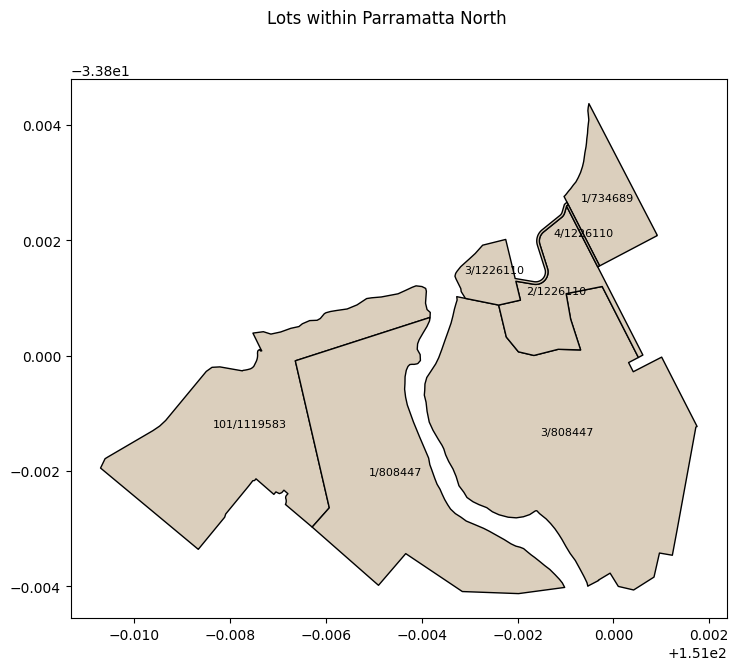

In [4]:
import geopandas as gpd
from sqlalchemy import text
import matplotlib.pyplot as plt

query = text("""
select DISTINCT ON (property_id)
	   property_id,
       legal_description,
       geometry as g
  from nsw_lrs.legal_description
  left join nsw_lrs.property_geometry using (property_id)
  where property_id IN :ps
  order by property_id
""")

fig, ax = plt.subplots(1, 1, figsize=(10, 7))
fig.suptitle("Lots within Parramatta North")

gdf = gpd\
  .read_postgis(query, engine, geom_col='g', params={ 'ps': properties })\

gdf.plot(color='#dbcfbd', edgecolor='black', ax=ax)

for idx, row in gdf.iterrows():
    plt.text(row.g.centroid.x, row.g.centroid.y, 
             row['legal_description'], fontsize=8, ha='center', color='black')


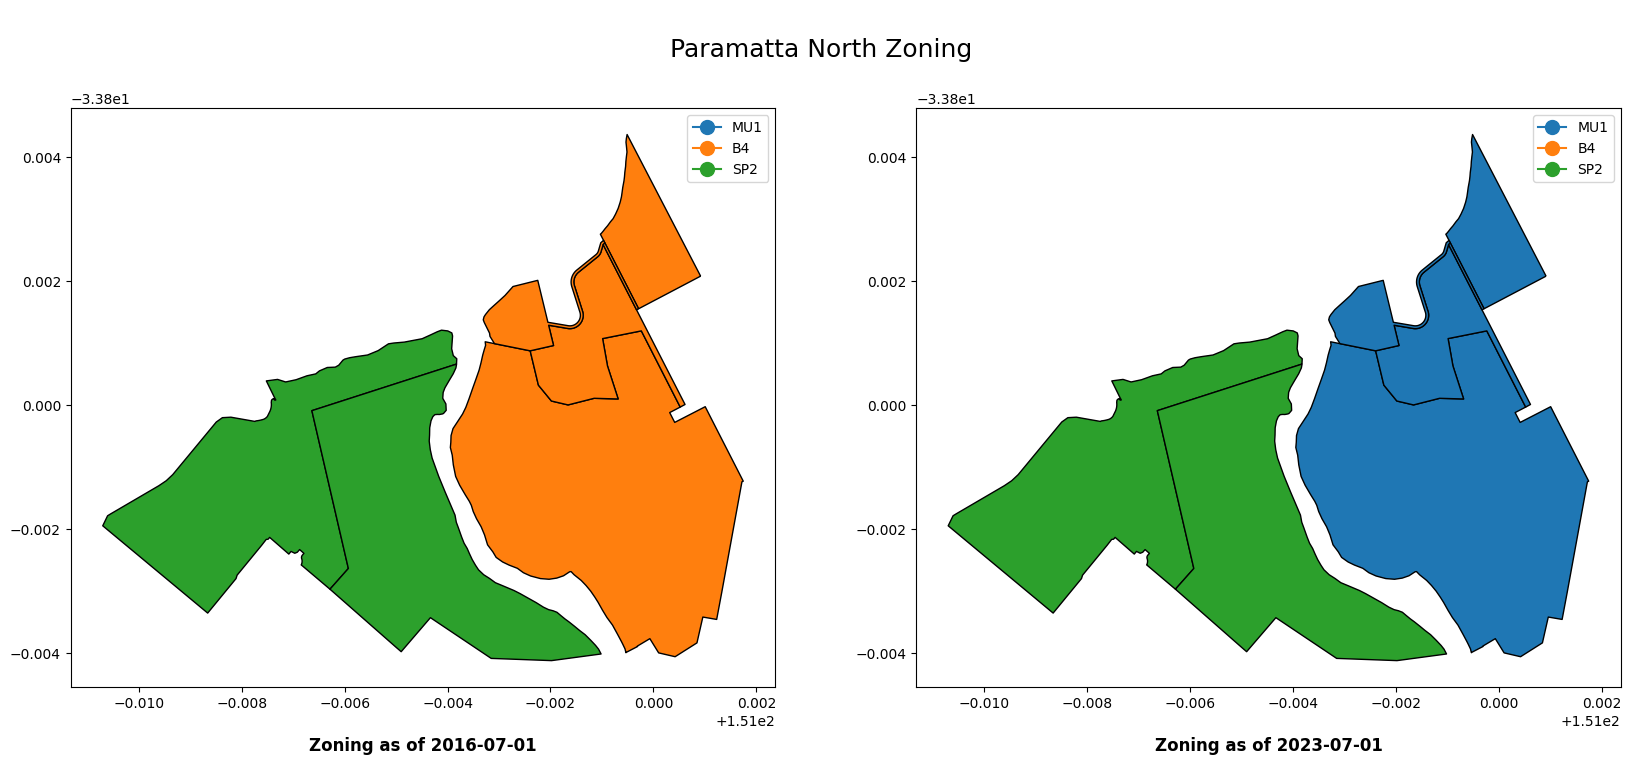

In [5]:
from datetime import datetime
import geopandas as gpd
from sqlalchemy import text
import matplotlib.pyplot as plt
import pandas as pd

query = text("""
select DISTINCT ON (property_id, z.zone_code)
	   property_id,
       z.zone_code,
       z.effective_date as zone_date,
       geometry as g
  from nsw_lrs.legal_description
  left join nsw_lrs.property_geometry using (property_id)
  left join nsw_lrs.zone_observation z using (property_id)
  where property_id IN :ps
  order by property_id, z.zone_code, z.effective_date
""")

fig, ax = plt.subplots(1, 2, figsize=(20, 8))
fig.suptitle("\nParamatta North Zoning", fontsize=18)

gdf = gpd.read_postgis(query, engine, geom_col='g', params={ 'ps': properties })

cats = set(gdf['zone_code'].unique())
cmap = plt.get_cmap('tab10')
color_mapping = {cat: cmap(i) for i, cat in enumerate(cats)}

for axis_index, date_max in [
    (0, datetime(2016, 7, 1).date()),
    (1, datetime(2023, 7, 1).date()),
]:
    sdf = gdf[gdf['zone_date'] <= date_max]
    sdf = sdf.loc[sdf.groupby(['property_id'])['zone_date'].idxmax()]
    sdf.plot(ax=ax[axis_index], 
             color=sdf['zone_code'].map(color_mapping),
             edgecolor='black', categorical=True)
    ax[axis_index].set_xlabel(f'\nZoning as of {date_max}', fontsize=12, fontweight='bold')
    ax[axis_index].legend(handles=[
        plt.Line2D([0], [0], marker='o', color=color_mapping[cat], markersize=10, label=cat)
        for cat in cats
    ])

# gdf[['property_id', 'zone_date', 'zone_code']]

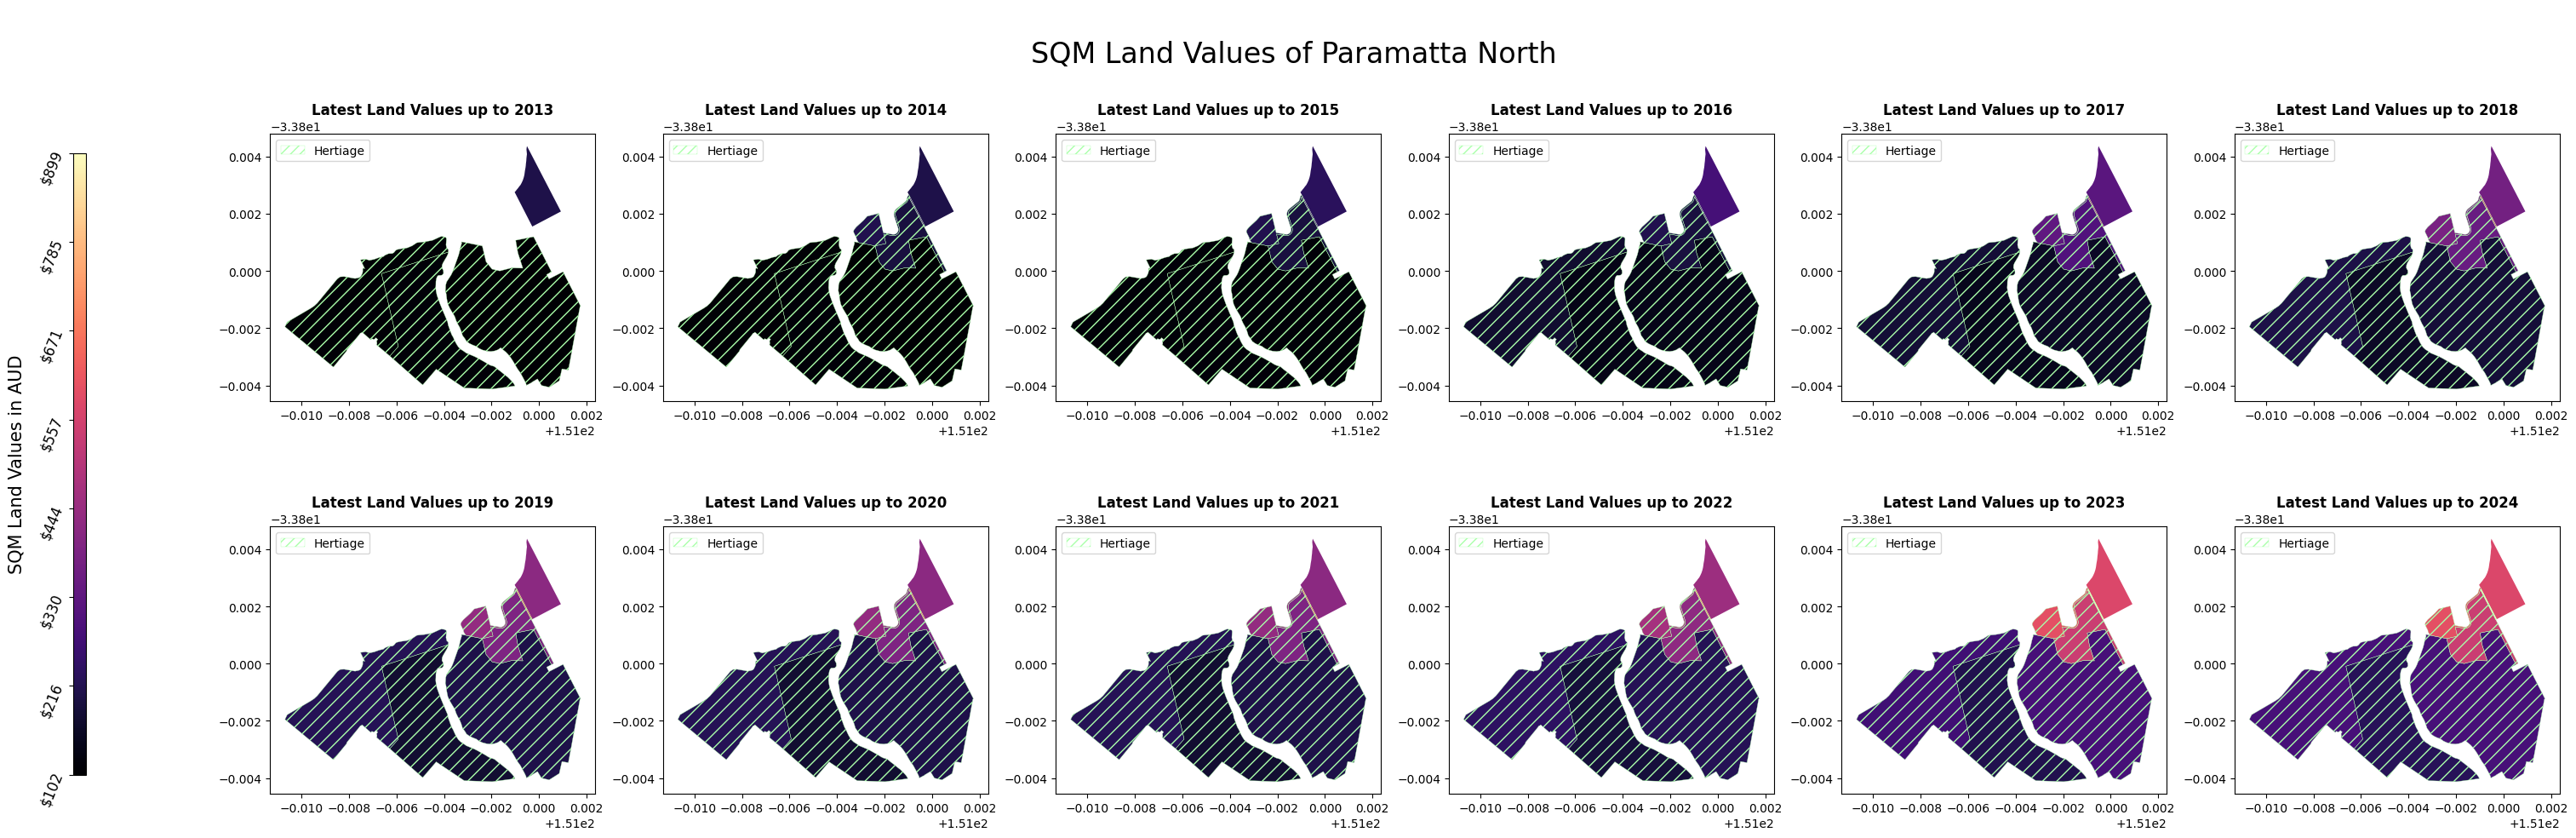

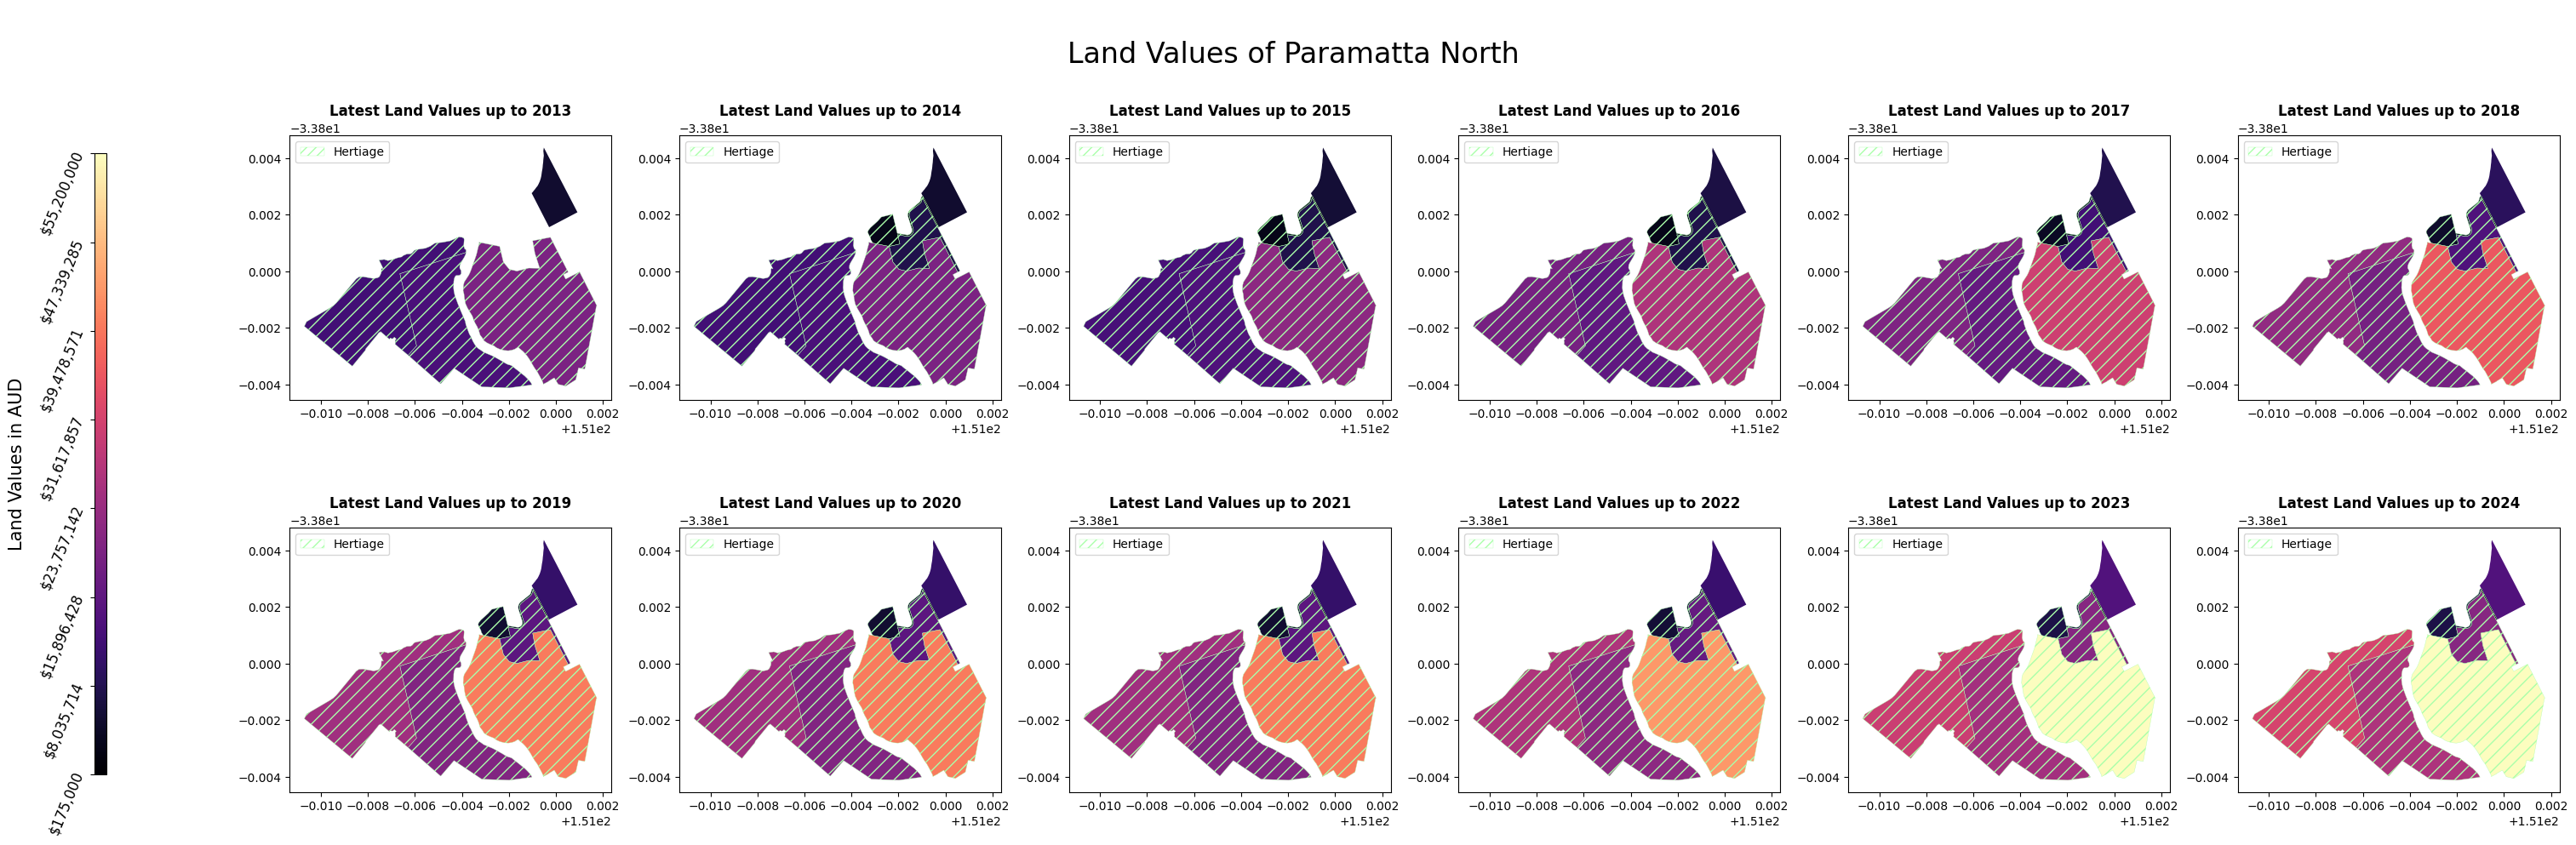

In [6]:
from datetime import datetime
import geopandas as gpd
from sqlalchemy import text
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib.patches import Patch
import numpy as np
import pandas as pd

abs_query = text("""
select property_id,
       valuation_base_date,
       land_value,
       (valuation_basis = '6A(1)') as has_heritage_restrictions,
       geometry as g
  from nsw_vg.land_valuation
  left join nsw_lrs.property_geometry using (property_id)
  where property_id IN :ps
  order by property_id, valuation_base_date
""")

sqm_query = text("""
select lv.property_id,
       valuation_base_date,
       (land_value / sqm_area) as land_value,
       (valuation_basis = '6A(1)') as has_heritage_restrictions,
       geometry as g
  from nsw_vg.land_valuation lv
  left join nsw_lrs.property_geometry using (property_id)
  join lateral (
    select *
      from nsw_lrs.property_area a
      where a.property_id = lv.property_id
        and a.source_id = lv.source_id
        and a.strata_lot_number IS NULL
      limit 1) pa ON TRUE
  where lv.property_id IN :ps
  order by lv.property_id, valuation_base_date
""")

for query, unit, title in [
    (sqm_query, "SQM Land Values", "\nSQM Land Values of Paramatta North"),
    (abs_query, "Land Values", "\nLand Values of Paramatta North"),
]:
    cmap_name = 'magma'
    rows, cols = 2, 6
    fig, ax = plt.subplots(rows, cols, figsize=(30, 10), constrained_layout=True)
    fig.suptitle(title, fontsize=24)
    # fig.suptitle("test")
    
    gdf = gpd.read_postgis(query, engine, geom_col='g', params={ 'ps': properties })
    
    vmin, vmax = gdf['land_value'].min(), gdf['land_value'].max()
    norm = mcolors.Normalize(vmin=vmin, vmax=vmax)
    ticks = 8
    tick_vs = [vmin + ((vmax - vmin) / (ticks - 1)) * i for i in range(0, ticks)]
    
    sm = plt.cm.ScalarMappable(cmap=plt.get_cmap(cmap_name), norm=norm)
    sm.set_array([])
    cbar = plt.colorbar(sm, ax=ax, shrink=0.8, aspect=50, location='left')
    cbar.set_label(f"{unit} in AUD", labelpad=10, fontsize=15)
    cbar.set_ticks(tick_vs)
    cbar.set_ticklabels([f"${int(tick):,}" for tick in tick_vs])
    cbar.ax.tick_params(labelsize=12, rotation=67.5)
    
    for index, year in enumerate(range(2013, 2025)):
        sax = ax[index // cols][index % cols]
        sax.set_title(f'Latest Land Values up to {year}', fontsize=12, fontweight='bold')
        sax.legend(handles=[
            Patch(facecolor='none', edgecolor='#aaffaa', hatch='///', linewidth=0.25, label='Hertiage')
        ], loc='upper left')
        
        sdf = gdf[gdf['valuation_base_date'] <= datetime(year, 1, 1).date()]
        sdf = sdf.loc[sdf.groupby(['property_id'])['valuation_base_date'].idxmax()]
        sdf.plot(ax=sax, column='land_value', cmap=cmap_name, norm=norm)
    
        sdf = sdf[sdf['has_heritage_restrictions']]
        sdf.plot(ax=sax, color='none', edgecolor='#aaffaa', hatch='//', linewidth=0.25)
    
    plt.show()
    